# Markov Chains - Team-7 

## Project revenues for the next 10 years.
## Discount rate: 10%
## What would be the value of the customer base in 2025.


** Srini Ananthakrishnan , Carles Poles-Mielgo and Bahman Roostaei. **

## Overview of the analysis:

** In this analysis we would like to predict the discounted total revenue of the enterprise beging year 2016 through the end of 2025. Our data includes the purchase amount and the purchase date of individual customers from the beginning of 2005 through the end of 2015. Based on the behavior we have decided to segment the customers to three major groups and 8 minor groups. The major groups are solely based on the customer recency while the minor group also includes the mean purchase amount as well. Our model takes into account the percentage of customers moving between these total 8 groups from 2014 to 2015. Based on this movement, we have constructed a Markov model that models the evolution of the customer behavior. We have projected that the enterprise discounted yearly revenue will decrease in 2025 by about 81 percent compared to the 2015 ! **

In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [3]:
sns.set(color_codes=True)

In [4]:
df = pd.read_csv('purchases.txt', sep="\t", header=None, names=['customer_id', 'purchase_amount', 'date_purchase'])

** Let's first take a look at the raw data: **

In [5]:
df.head()

,customer_id,purchase_amount,date_purchase
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09
4,1940,70.0,2013-01-25


** We have little over 51000 records: **

In [6]:
df.shape

(51243, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 3 columns):
customer_id        51243 non-null int64
purchase_amount    51243 non-null float64
date_purchase      51243 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [8]:
df['date_purchase'] =  pd.to_datetime(df['date_purchase'])
df['year_purchase'] = df['date_purchase'].apply(lambda x: x.year)

In [9]:
df.head()

,customer_id,purchase_amount,date_purchase,year_purchase
0,760,25.0,2009-11-06,2009
1,860,50.0,2012-09-28,2012
2,1200,100.0,2005-10-25,2005
3,1420,50.0,2009-07-09,2009
4,1940,70.0,2013-01-25,2013


** Also let's take a look at the overall evolution of customer purchase: **

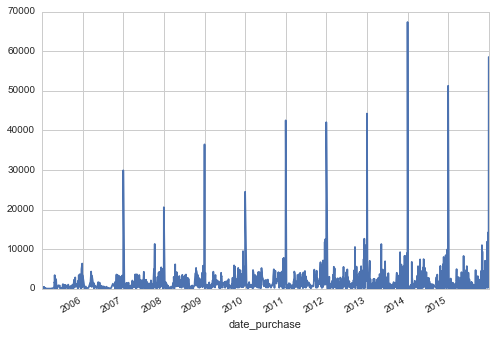

In [170]:
df_grouped = df.groupby('date_purchase')
sales_timeseries = df_grouped['purchase_amount'].sum()
sales_timeseries.plot();

In [171]:
def diffdays(diffday):
    date_format = "%Y/%m/%d"
    day1 = datetime.strptime('2016/01/01', date_format)
    day2 = datetime.strptime(diffday, date_format)
    delta = day1 - day2
    return delta.days

diffdays('2009/11/06');

In [10]:
df['daydiff']=df['date_purchase'].apply(lambda x:(datetime.strptime('2016-01-01','%Y-%M-%d')-x).days)

** We now exctract recency for each customer assuming we are at the end of 2015: **

In [11]:
df.head()

,customer_id,purchase_amount,date_purchase,year_purchase,daydiff
0,760,25.0,2009-11-06,2009,2247
1,860,50.0,2012-09-28,2012,1190
2,1200,100.0,2005-10-25,2005,3720
3,1420,50.0,2009-07-09,2009,2367
4,1940,70.0,2013-01-25,2013,1071


** For constructing our Markov model we need to find the Key Performance Indicators (KPI) of the business for 2015 and 2014: **

## KPIs for customers in 2015.

In [14]:
def summary_2015(df):
    df['recency'] = df.daydiff.min()
    df['first_purchase'] = df.daydiff.max()
    df['frequency'] = df.shape[0]
    df['amount'] = df.purchase_amount.mean()
    return df

In [15]:
customers_2015 = df.groupby('customer_id').apply(summary_2015)
customers_2015.head()

,customer_id,purchase_amount,date_purchase,year_purchase,daydiff,recency,first_purchase,frequency,amount
0,760,25.0,2009-11-06,2009,2247,1273,3293,5,38.000000
1,860,50.0,2012-09-28,2012,1190,237,4008,10,54.000000
2,1200,100.0,2005-10-25,2005,3720,1192,3907,9,102.777778
3,1420,50.0,2009-07-09,2009,2367,24,3810,34,51.029412
4,1940,70.0,2013-01-25,2013,1071,686,3957,10,47.500000


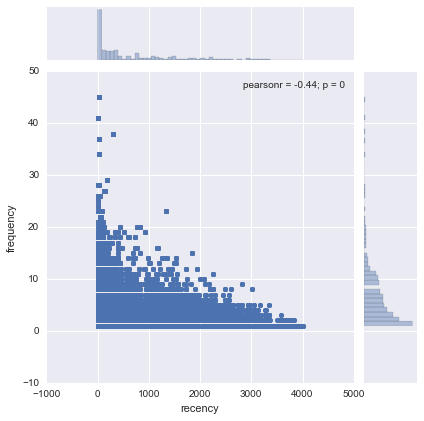

In [16]:
sns.jointplot(x="recency", y="frequency", data=customers_2015);

** We can see in the above that recency and frequency have negative correlation. **

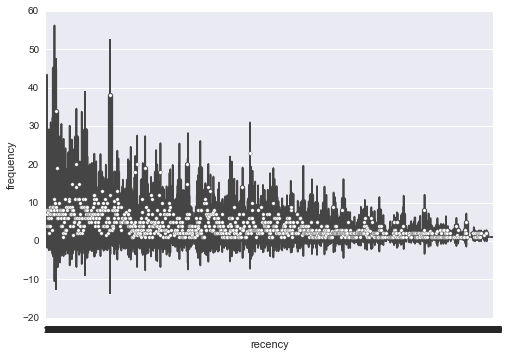

In [17]:
sns.violinplot(x="recency", y="frequency", data=customers_2015);

In [20]:
customers_2015_df_corr = customers_2015[['recency', 'frequency', 'first_purchase', 'amount']].corr()

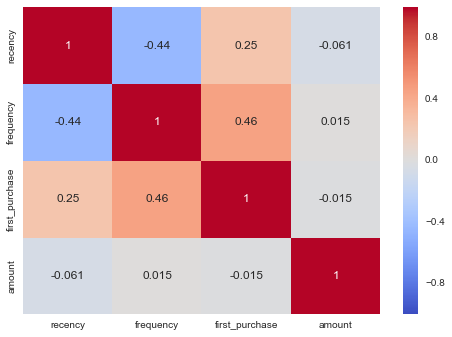

In [21]:
sns.heatmap(customers_2015_df_corr, annot=True, cmap='coolwarm');

#### Not too strong positive correlation between `frequency` and `first_purchase`.

In [22]:
customers_2015.drop(['purchase_amount','date_purchase','year_purchase','daydiff'], axis=1, inplace=True)

In [23]:
customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount
0,760,1273,3293,5,38.000000
1,860,237,4008,10,54.000000
2,1200,1192,3907,9,102.777778
3,1420,24,3810,34,51.029412
4,1940,686,3957,10,47.500000


## Segmenting customers in 2015.

** Now we will segment the customers accoding to their behavior as follows:
These are the segments we define:   **

   **inactive **  : No purchase in the past three years. 
   
   **cold **      : No purchase between last three and two years. 
   
   **warm **      : No purchase between last two and one year.
   
          new warm: warm but their first purchase happened less than two years ago.
          warm low value: warm but their purchase amount less than 100 USD.
          warm high value: warm and purchase amount more than 100 USD.
        
 ** active**      : Made purchase during last year.
 
         new active: active but their first purchase was less than a year ago.
         active low value: active but their purchase amount less than 100 USD.
         active high value: active and purchase amount more than 100 USD. 

In [24]:
def major_segments(recency):
    if recency > 3*365:
        return 'inactive'
    elif (recency <= 3*365) and (recency > 2*365):
        return 'cold'
    elif (recency <= 2*365) and (recency > 1*365):
        return 'warm'
    elif (recency <= 365):
        return 'active'
    else:
        # Do nothing
        pass

In [25]:
customers_2015['segment']=customers_2015['recency'].apply(lambda row: major_segments(row))

In [34]:
customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount,segment
0,760,1273,3293,5,38.000000,inactive
1,860,237,4008,10,54.000000,active
2,1200,1192,3907,9,102.777778,inactive
3,1420,24,3810,34,51.029412,active
4,1940,686,3957,10,47.500000,warm


In [35]:
copy_customers_2015 = customers_2015.copy()

In [36]:
copy_customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount,segment
0,760,1273,3293,5,38.000000,inactive
1,860,237,4008,10,54.000000,active
2,1200,1192,3907,9,102.777778,inactive
3,1420,24,3810,34,51.029412,active
4,1940,686,3957,10,47.500000,warm


In [37]:
def minor_segments(row):
    if (row['segment'] == 'warm') and (row['first_purchase'] <= 2*365):
        return 'new_warm'
    elif (row['segment'] == 'warm') and (row['amount'] < 100):
        return 'warm_low_value'
    elif (row['segment'] == 'warm') and (row['amount'] >= 100):
        return 'warm_high_value'
    elif (row['segment'] == 'active') and (row['first_purchase'] <= 365):
        return 'new_active'
    elif (row['segment'] == 'active') and (row['amount'] < 100):
        return 'active_low_value'
    elif (row['segment'] == 'active') and (row['amount'] >= 100):
        return 'active_high_value'
    else:
        return row['segment']

In [38]:
copy_customers_2015['segment'] = copy_customers_2015.apply(minor_segments, axis=1)

In [39]:
copy_customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount,segment
0,760,1273,3293,5,38.000000,inactive
1,860,237,4008,10,54.000000,active_low_value
2,1200,1192,3907,9,102.777778,inactive
3,1420,24,3810,34,51.029412,active_low_value
4,1940,686,3957,10,47.500000,warm_low_value


** the percentage of each segment population in 2015: **

In [47]:
total_2015 = sum(copy_customers_2015.segment.value_counts())
copy_customers_2015.segment.value_counts()/total_2015

active_low_value     0.383740
inactive             0.324278
cold                 0.085534
warm_low_value       0.079679
active_high_value    0.065843
new_active           0.030853
new_warm             0.019125
warm_high_value      0.010948
Name: segment, dtype: float64

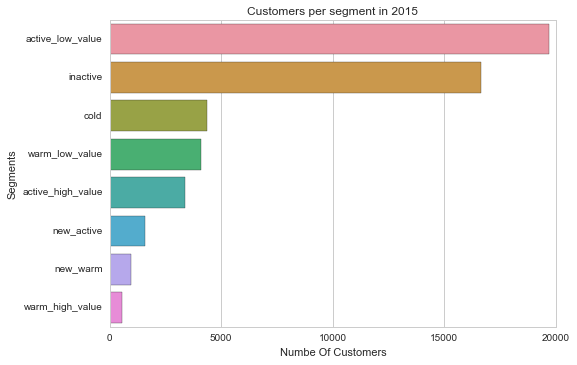

In [48]:
data = copy_customers_2015.segment.value_counts()
data = data.to_frame('value_count')
sns.set_style("whitegrid")
ax = sns.barplot(x=data.value_count, y=data.index, data=data)
ax.set_ylabel("Segments")
ax.set_xlabel("Numbe Of Customers")
ax.set_title("Customers per segment in 2015");

## KPIs for customers in 2014.

In [49]:
def summary_2014(df):
    df['recency'] = df.daydiff.min() - 365
    df['first_purchase'] = df.daydiff.max() - 365
    df['frequency'] = df.shape[0]
    df['amount'] = df.purchase_amount.mean()
    return df

In [50]:
df_adj = df[df['daydiff'] > 365]
customers_2014 = df_adj.groupby('customer_id').apply(summary_2014)

In [51]:
customers_2014.head()

,customer_id,purchase_amount,date_purchase,year_purchase,daydiff,recency,first_purchase,frequency,amount
0,760,25.0,2009-11-06,2009,2247,908,2928,5,38.000000
1,860,50.0,2012-09-28,2012,1190,267,3643,9,53.333333
2,1200,100.0,2005-10-25,2005,3720,827,3542,9,102.777778
3,1420,50.0,2009-07-09,2009,2367,93,3445,31,51.129032
4,1940,70.0,2013-01-25,2013,1071,321,3592,10,47.500000


In [52]:
customers_2014['segment']=customers_2014['recency'].apply(lambda row: major_segments(row))

In [53]:
customers_2014.head()

,customer_id,purchase_amount,date_purchase,year_purchase,daydiff,recency,first_purchase,frequency,amount,segment
0,760,25.0,2009-11-06,2009,2247,908,2928,5,38.000000,cold
1,860,50.0,2012-09-28,2012,1190,267,3643,9,53.333333,active
2,1200,100.0,2005-10-25,2005,3720,827,3542,9,102.777778,cold
3,1420,50.0,2009-07-09,2009,2367,93,3445,31,51.129032,active
4,1940,70.0,2013-01-25,2013,1071,321,3592,10,47.500000,active


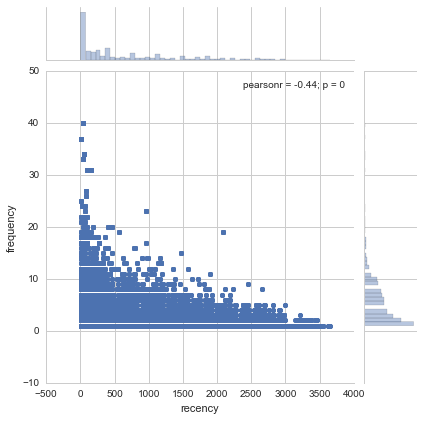

In [54]:
sns.jointplot(x="recency", y="frequency", data=customers_2014);

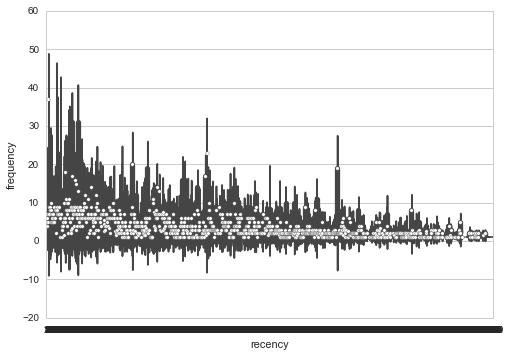

In [55]:
sns.violinplot(x="recency", y="frequency", data=customers_2014);

In [58]:
customers_2014_df_corr = customers_2014[['recency', 'frequency', 'first_purchase', 'amount']].corr()

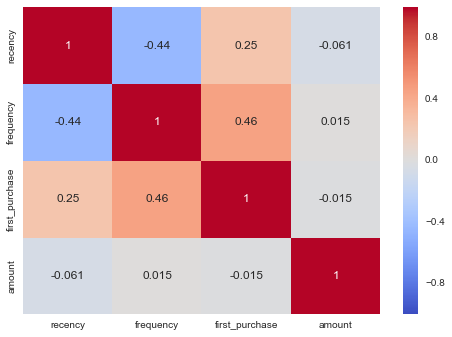

In [59]:
sns.heatmap(customers_2015_df_corr, annot=True, cmap='coolwarm');

#### Not too strong positive correlation between `frequency` and `first_purchase`.

In [60]:
copy_customers_2014 = customers_2014.copy()

In [61]:
copy_customers_2014['segment'] = copy_customers_2014.apply(minor_segments, axis=1)

In [62]:
copy_customers_2014.head()

,customer_id,purchase_amount,date_purchase,year_purchase,daydiff,recency,first_purchase,frequency,amount,segment
0,760,25.0,2009-11-06,2009,2247,908,2928,5,38.000000,cold
1,860,50.0,2012-09-28,2012,1190,267,3643,9,53.333333,active_low_value
2,1200,100.0,2005-10-25,2005,3720,827,3542,9,102.777778,cold
3,1420,50.0,2009-07-09,2009,2367,93,3445,31,51.129032,active_low_value
4,1940,70.0,2013-01-25,2013,1071,321,3592,10,47.500000,active_low_value


** the percentage of each segment population in 2014: **

In [63]:
total_2014 = sum(copy_customers_2014.segment.value_counts())
copy_customers_2014.segment.value_counts()/total_2014

active_low_value     0.376571
inactive             0.288660
cold                 0.107734
warm_low_value       0.092572
active_high_value    0.060072
new_active           0.034165
new_warm             0.029348
warm_high_value      0.010878
Name: segment, dtype: float64

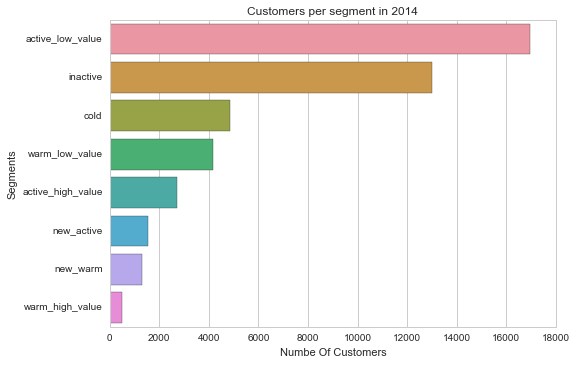

In [64]:
data = copy_customers_2014.segment.value_counts()
data = data.to_frame('value_count')
sns.set_style("whitegrid")
ax = sns.barplot(x=data.value_count, y=data.index, data=data)
ax.set_ylabel("Segments")
ax.set_xlabel("Numbe Of Customers")
ax.set_title("Customers per segment in 2014");

## Transition Matrix

In [65]:
copy_customers_2014.segment.value_counts()

active_low_value     16963
inactive             13003
cold                  4853
warm_low_value        4170
active_high_value     2706
new_active            1539
new_warm              1322
warm_high_value        490
Name: segment, dtype: int64

In [66]:
copy_customers_2015.segment.value_counts()

active_low_value     19664
inactive             16617
cold                  4383
warm_low_value        4083
active_high_value     3374
new_active            1581
new_warm               980
warm_high_value        561
Name: segment, dtype: int64

In [67]:
merged_customers = pd.merge(copy_customers_2014, copy_customers_2015, on='customer_id', how='right')

In [68]:
merged_customers.segment_x.value_counts()

active_low_value     155281
inactive              36574
warm_low_value        26854
active_high_value     22776
cold                  20112
warm_high_value        3024
new_active             2556
new_warm               1630
Name: segment_x, dtype: int64

In [69]:
merged_customers.segment_y.value_counts()

active_low_value     144078
inactive              50171
warm_low_value        26419
active_high_value     23065
cold                  20213
warm_high_value        3785
new_active             1581
new_warm               1076
Name: segment_y, dtype: int64

In [70]:
merged_customers.shape

(270388, 15)

In [71]:
merged_customers.head()

,customer_id,purchase_amount,date_purchase,year_purchase,daydiff,recency_x,first_purchase_x,frequency_x,amount_x,segment_x,recency_y,first_purchase_y,frequency_y,amount_y,segment_y
0,760.0,25.0,2009-11-06,2009.0,2247.0,908.0,2928.0,5.0,38.0,cold,1273,3293,5,38.0,inactive
1,760.0,50.0,2008-10-15,2008.0,2634.0,908.0,2928.0,5.0,38.0,cold,1273,3293,5,38.0,inactive
2,760.0,60.0,2007-10-17,2007.0,2998.0,908.0,2928.0,5.0,38.0,cold,1273,3293,5,38.0,inactive
3,760.0,30.0,2006-12-26,2006.0,3293.0,908.0,2928.0,5.0,38.0,cold,1273,3293,5,38.0,inactive
4,760.0,25.0,2012-07-07,2012.0,1273.0,908.0,2928.0,5.0,38.0,cold,1273,3293,5,38.0,inactive


** We form the contingency table for the year 2014 and 2015: **

In [72]:
transition = pd.crosstab(merged_customers['segment_x'], merged_customers['segment_y'], margins=False, dropna=False)
transition

segment_y,active_high_value,active_low_value,cold,inactive,new_active,new_warm,warm_high_value,warm_low_value
segment_x,,,,,,,,
active_high_value,18973,18,0,0,0,0,3785,0
active_low_value,1435,127427,0,0,0,0,0,26419
cold,626,2515,0,16971,0,0,0,0
inactive,443,2931,0,33200,0,0,0,0
new_active,200,1280,0,0,0,1076,0,0
new_warm,44,255,1331,0,0,0,0,0
warm_high_value,1314,6,1704,0,0,0,0,0
warm_low_value,30,9646,17178,0,0,0,0,0


** we normalize the transition matrix (contingency table) : **

In [75]:
transition = transition / transition.sum(axis=0)
transition = transition.fillna(0)

## Making Predictions with the Transition Matrix

** Given the transition matrix is $Q$ and the state vector (the population of each segment) being $p(0)$ in the year 2015 we project the population of each segment after $t$- years to be:
$$ p(t) = Q^t . p(0) $$ **

In [76]:
state_vector_2015 = copy_customers_2015.segment.value_counts()
state_vector_2015

active_low_value     19664
inactive             16617
cold                  4383
warm_low_value        4083
active_high_value     3374
new_active            1581
new_warm               980
warm_high_value        561
Name: segment, dtype: int64

In [77]:
transition

segment_y,active_high_value,active_low_value,cold,inactive,new_active,new_warm,warm_high_value,warm_low_value
segment_x,,,,,,,,
active_high_value,0.822588,0.000125,0.000000,0.000000,0.0,0.0,1.0,0.0
active_low_value,0.062215,0.884431,0.000000,0.000000,0.0,0.0,0.0,1.0
cold,0.027141,0.017456,0.000000,0.338263,0.0,0.0,0.0,0.0
inactive,0.019207,0.020343,0.000000,0.661737,0.0,0.0,0.0,0.0
new_active,0.008671,0.008884,0.000000,0.000000,0.0,1.0,0.0,0.0
new_warm,0.001908,0.001770,0.065849,0.000000,0.0,0.0,0.0,0.0
warm_high_value,0.056969,0.000042,0.084302,0.000000,0.0,0.0,0.0,0.0
warm_low_value,0.001301,0.066950,0.849849,0.000000,0.0,0.0,0.0,0.0


## Using the transition matrix to make predictions

In [80]:
state_vector_2016 = transition.dot(state_vector_2015.values)
state_vector_2016

segment_x
active_high_value    17157.453065
active_low_value     16480.989364
cold                  2204.886320
inactive              3417.592068
new_active            1899.136132
new_warm               355.536983
warm_high_value       1490.435417
warm_low_value        4862.970652
dtype: float64

In [81]:
state_vector_2017 = transition.dot(state_vector_2016.values)
state_vector_2017

segment_x
active_high_value    15606.015215
active_low_value     20506.722023
cold                  1909.399754
inactive              2926.358008
new_active             650.730150
new_warm               207.088662
warm_high_value       1164.013457
warm_low_value        2999.536599
dtype: float64

In [82]:
state_vector_2018 = transition.dot(state_vector_2017.values)
state_vector_2018

segment_x
active_high_value    14003.901517
active_low_value     22107.245899
cold                  1771.398760
inactive              2653.388566
new_active             524.594002
new_warm               191.796691
warm_high_value       1050.886406
warm_low_value        3015.921877
dtype: float64

In [83]:
state_vector_2019 = transition.dot(state_vector_2018.values)
state_vector_2019

segment_x
active_high_value    12573.094381
active_low_value     23439.507288
cold                  1663.519250
inactive              2474.543177
new_active             509.629044
new_warm               182.485954
warm_high_value        948.047763
warm_low_value        3003.712859
dtype: float64

In [84]:
state_vector_2020 = transition.dot(state_vector_2019.values)
state_vector_2020

segment_x
active_high_value    11293.456917
active_low_value     24516.572734
cold                  1587.445074
inactive              2355.816055
new_active             499.747481
new_warm               175.010681
warm_high_value        857.496493
warm_low_value        2999.365239
dtype: float64

In [85]:
state_vector_2021 = transition.dot(state_vector_2020.values)
state_vector_2021

segment_x
active_high_value    10150.425353
active_low_value     25385.201556
cold                  1531.354885
inactive              2274.583371
new_active             490.745015
new_warm               169.466462
warm_high_value        778.227905
warm_low_value        3005.158646
dtype: float64

In [86]:
state_vector_2022 = transition.dot(state_vector_2021.values)
state_vector_2022

segment_x
active_high_value     9131.020851
active_low_value     26088.122666
cold                  1488.016828
inactive              2216.545615
new_active             483.006367
new_warm               165.129852
warm_high_value        708.417691
warm_low_value        3014.158306
dtype: float64

In [87]:
state_vector_2023 = transition.dot(state_vector_2022.values)
state_vector_2023

segment_x
active_high_value     8222.748201
active_low_value     26655.384566
cold                  1452.987520
inactive              2172.860236
new_active             476.075157
new_warm               161.575510
warm_high_value        646.718573
warm_low_value        3023.062047
dtype: float64

In [88]:
state_vector_2024 = transition.dot(state_vector_2023.values)
state_vector_2024

segment_x
active_high_value     7413.985463
active_low_value     27109.483504
cold                  1423.461244
inactive              2138.047082
new_active             469.684647
new_warm               158.540189
warm_high_value        592.045370
warm_low_value        3030.089153
dtype: float64

In [89]:
state_vector_2025 = transition.dot(state_vector_2024.values)
state_vector_2025

segment_x
active_high_value     6694.090196
active_low_value     27467.812071
cold                  1397.661529
inactive              2108.714163
new_active             463.670676
new_warm               155.856782
warm_high_value        543.500396
warm_low_value        3034.346192
dtype: float64

In [94]:
segments_df = pd.DataFrame(index=['active_high_value','active_low_value','cold','inactive','new_active','new_warm','warm_high_value','warm_low_value'])
segments_df['2015'] = state_vector_2015.values
segments_df['2016'] = state_vector_2016.values
segments_df['2017'] = state_vector_2017.values
segments_df['2018'] = state_vector_2018.values
segments_df['2019'] = state_vector_2019.values
segments_df['2020'] = state_vector_2020.values
segments_df['2021'] = state_vector_2021.values
segments_df['2022'] = state_vector_2022.values
segments_df['2023'] = state_vector_2023.values
segments_df['2024'] = state_vector_2024.values
segments_df['2025'] = state_vector_2025.values
segments_df

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
active_high_value,19664,17157.453065,15606.015215,14003.901517,12573.094381,11293.456917,10150.425353,9131.020851,8222.748201,7413.985463,6694.090196
active_low_value,16617,16480.989364,20506.722023,22107.245899,23439.507288,24516.572734,25385.201556,26088.122666,26655.384566,27109.483504,27467.812071
cold,4383,2204.886320,1909.399754,1771.398760,1663.519250,1587.445074,1531.354885,1488.016828,1452.987520,1423.461244,1397.661529
inactive,4083,3417.592068,2926.358008,2653.388566,2474.543177,2355.816055,2274.583371,2216.545615,2172.860236,2138.047082,2108.714163
new_active,3374,1899.136132,650.730150,524.594002,509.629044,499.747481,490.745015,483.006367,476.075157,469.684647,463.670676
new_warm,1581,355.536983,207.088662,191.796691,182.485954,175.010681,169.466462,165.129852,161.575510,158.540189,155.856782
warm_high_value,980,1490.435417,1164.013457,1050.886406,948.047763,857.496493,778.227905,708.417691,646.718573,592.045370,543.500396
warm_low_value,561,4862.970652,2999.536599,3015.921877,3003.712859,2999.365239,3005.158646,3014.158306,3023.062047,3030.089153,3034.346192


** Here we show how each segment population is changing accroding to our projection. **

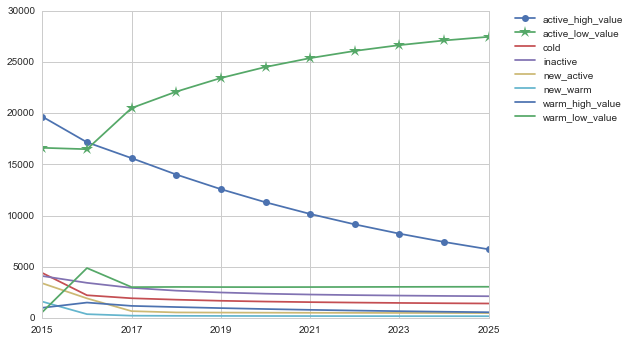

In [108]:
segments_df.loc['active_high_value'].plot(marker='o');
segments_df.loc['active_low_value'].plot(marker='*',markersize=12);
segments_df.loc['cold'].plot();
segments_df.loc['inactive'].plot();
segments_df.loc['new_active'].plot();
segments_df.loc['new_warm'].plot();
segments_df.loc['warm_high_value'].plot();
segments_df.loc['warm_low_value'].plot();
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Computing the (discounted) Customer Lifetime Value (CLV) 

** Here we apply the purchase amount of customers to the population evolution to find out the yearly revenue projections: **

### Yearly revenue per segment

In [110]:
def revenue(df):
    return df.purchase_amount.sum()

In [111]:
df_yp_2015 = df[df['year_purchase'] == 2015]
revenue_2015 = df_yp_2015.groupby('customer_id').apply(revenue)

In [112]:
revenue_2015_df = pd.DataFrame()
revenue_2015_df['customer_id'] = revenue_2015.index
revenue_2015_df['revenue_2015'] = revenue_2015.values
revenue_2015_df.head()

,customer_id,revenue_2015
0,80,80.0
1,480,45.0
2,830,50.0
3,850,60.0
4,860,60.0


In [114]:
actual = pd.merge(copy_customers_2015, revenue_2015_df, on='customer_id', how='right')
actual.head()

,customer_id,recency,first_purchase,frequency,amount,segment,revenue_2015
0,860,237,4008,10,54.0,active_low_value,60.0
1,860,237,4008,10,54.0,active_low_value,60.0
2,860,237,4008,10,54.0,active_low_value,60.0
3,860,237,4008,10,54.0,active_low_value,60.0
4,860,237,4008,10,54.0,active_low_value,60.0


In [118]:
actual.describe().drop('customer_id',axis=1)

,recency,first_purchase,frequency,amount,revenue_2015
count,24619.000000,24619.000000,24619.000000,24619.000000,24619.000000
mean,98.155165,2329.044681,8.113936,69.798779,102.086527
std,103.418552,1159.378376,5.681429,141.555296,230.196141
min,1.000000,1.000000,1.000000,5.000000,5.000000
25%,15.000000,1289.000000,4.000000,29.285714,30.000000
50%,57.000000,2598.000000,7.000000,40.625000,50.000000
75%,177.000000,3288.000000,10.000000,66.000000,100.000000
max,360.000000,4012.000000,45.000000,4500.000000,4500.000000


In [119]:
revenue_segment = actual.groupby('segment').agg({'revenue_2015':lambda x: x.mean()})
revenue_segment

,revenue_2015
segment,
active_high_value,360.945465
active_low_value,59.339097
new_active,81.337261


In [120]:
yearly_revenue = revenue_segment.revenue_2015
yearly_revenue

segment
active_high_value    360.945465
active_low_value      59.339097
new_active            81.337261
Name: revenue_2015, dtype: float64

In [121]:
s = pd.Series([0,0,0,0,0],index=['cold','inactive','new_warm','warm_high_value','warm_low_value'])

In [122]:
yearly_revenue = yearly_revenue.append(s)

In [123]:
yearly_revenue.reindex(['active_high_value','active_low_value','cold','inactive','new_active','new_warm','warm_high_value','warm_low_value'])

segment
active_high_value    360.945465
active_low_value      59.339097
cold                   0.000000
inactive               0.000000
new_active            81.337261
new_warm               0.000000
warm_high_value        0.000000
warm_low_value         0.000000
dtype: float64

In [125]:
data = segments_df.T

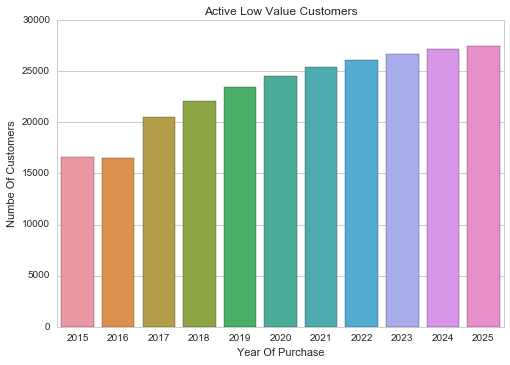

In [126]:
sns.set_style("whitegrid")
ax = sns.barplot(x=data.index, y=data.active_low_value, data=data)
ax.set_xlabel("Year Of Purchase")
ax.set_ylabel("Numbe Of Customers")
ax.set_title("Active Low Value Customers");

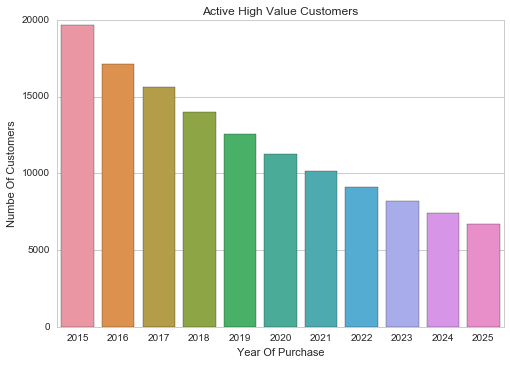

In [127]:
sns.set_style("whitegrid")
ax = sns.barplot(x=data.index, y=data.active_high_value, data=data)
ax.set_xlabel("Year Of Purchase")
ax.set_ylabel("Numbe Of Customers")
ax.set_title("Active High Value Customers");

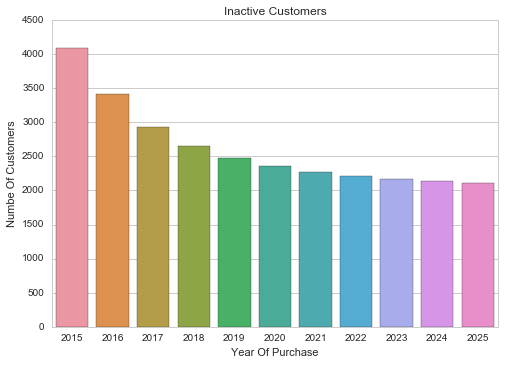

In [128]:
sns.set_style("whitegrid")
ax = sns.barplot(x=data.index, y=data.inactive, data=data)
ax.set_xlabel("Year Of Purchase")
ax.set_ylabel("Numbe Of Customers")
ax.set_title("Inactive Customers");

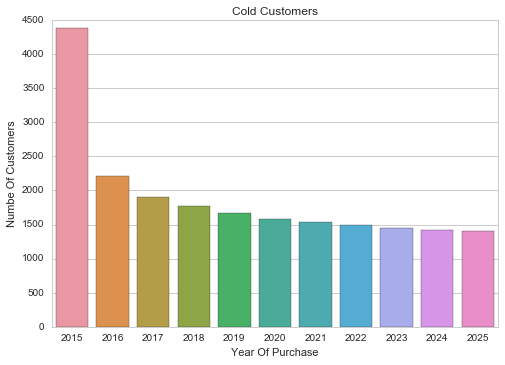

In [129]:
sns.set_style("whitegrid")
ax = sns.barplot(x=data.index, y=data.cold, data=data)
ax.set_xlabel("Year Of Purchase")
ax.set_ylabel("Numbe Of Customers")
ax.set_title("Cold Customers");

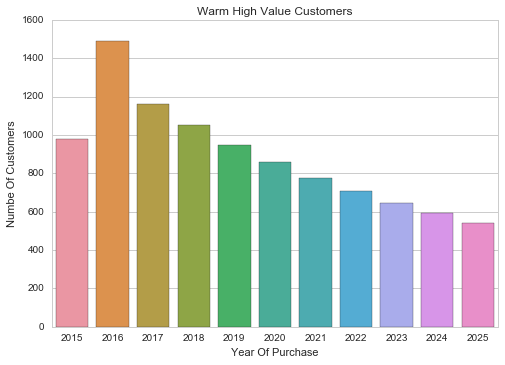

In [130]:
sns.set_style("whitegrid")
ax = sns.barplot(x=data.index, y=data.warm_high_value, data=data)
ax.set_xlabel("Year Of Purchase")
ax.set_ylabel("Numbe Of Customers")
ax.set_title("Warm High Value Customers");

### Projecting the revenue per segment :

In [131]:
import numpy as np

In [132]:
def prd(u,v):
    return [u[i]*v[i] for i in range(len(u))]

In [133]:
y_2015 = prd(segments_df['2015'],yearly_revenue)
y_2016 = prd(segments_df['2016'],yearly_revenue)
y_2017 = prd(segments_df['2017'],yearly_revenue)
y_2018 = prd(segments_df['2018'],yearly_revenue)
y_2019 = prd(segments_df['2019'],yearly_revenue)
y_2020 = prd(segments_df['2020'],yearly_revenue)
y_2021 = prd(segments_df['2021'],yearly_revenue)
y_2022 = prd(segments_df['2022'],yearly_revenue)
y_2023 = prd(segments_df['2023'],yearly_revenue)
y_2024 = prd(segments_df['2024'],yearly_revenue)
y_2025 = prd(segments_df['2025'],yearly_revenue)

In [134]:
revenue_per_seg = pd.DataFrame({'2015': y_2015,'2016': y_2016,'2017': y_2017,'2018': y_2018,
                                 '2019': y_2019,'2020': y_2020,'2021': y_2021,'2022': y_2022,
                                 '2023': y_2023,'2024': y_2024,'2025': y_2025},
                                 index=['active_high_value','active_low_value','cold','inactive','new_active',
                                        'new_warm','warm_high_value','warm_low_value'])

In [135]:
revenue_per_seg.head()

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
active_high_value,7.097632e+06,6.192905e+06,5.632920e+06,5.054645e+06,4.538201e+06,4.076322e+06,3.663750e+06,3.295801e+06,2.967964e+06,2.676044e+06,2.416202e+06
active_low_value,9.860378e+05,9.779670e+05,1.216850e+06,1.311824e+06,1.390879e+06,1.454791e+06,1.506335e+06,1.548046e+06,1.581706e+06,1.608652e+06,1.629915e+06
cold,3.565012e+05,1.793394e+05,1.553053e+05,1.440807e+05,1.353061e+05,1.291184e+05,1.245562e+05,1.210312e+05,1.181820e+05,1.157804e+05,1.136820e+05
inactive,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
new_active,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


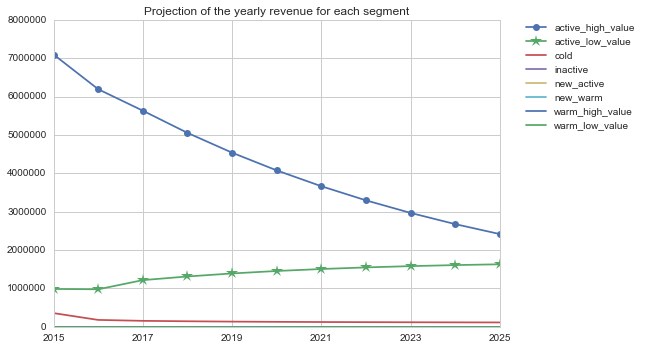

In [175]:
revenue_per_seg.loc['active_high_value'].plot(marker='o');
revenue_per_seg.loc['active_low_value'].plot(marker='*',markersize=12);
revenue_per_seg.loc['cold'].plot();
revenue_per_seg.loc['inactive'].plot();
revenue_per_seg.loc['new_active'].plot();
revenue_per_seg.loc['new_warm'].plot();
revenue_per_seg.loc['warm_high_value'].plot();
revenue_per_seg.loc['warm_low_value'].plot();
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Projection of the yearly revenue for each segment');

In [138]:
total_yearly_rev = revenue_per_seg.sum(axis=0)

In [139]:
total_yearly_rev

2015    8.440171e+06
2016    7.350211e+06
2017    7.005076e+06
2018    6.510549e+06
2019    6.064387e+06
2020    5.660232e+06
2021    5.294641e+06
2022    4.964877e+06
2023    4.667852e+06
2024    4.400477e+06
2025    4.159799e+06
dtype: float64

In [142]:
data = revenue_per_seg.sum(axis=0)
data = data.to_frame('yearly_revenue')

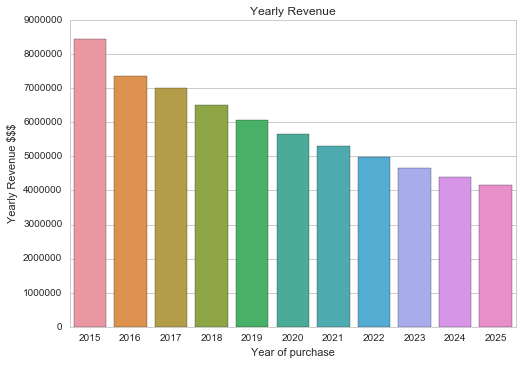

In [143]:
sns.set_style("whitegrid")
ax = sns.barplot(x=data.index, y=data.yearly_revenue, data=data)
ax.set_xlabel("Year of purchase")
ax.set_ylabel("Yearly Revenue $$$")
ax.set_title("Yearly Revenue");

## Cumulative yearly revenue

In [144]:
total_yr_cusum = total_yearly_rev.cumsum()
total_yr_cusum

2015    8.440171e+06
2016    1.579038e+07
2017    2.279546e+07
2018    2.930601e+07
2019    3.537039e+07
2020    4.103063e+07
2021    4.632527e+07
2022    5.129014e+07
2023    5.595800e+07
2024    6.035847e+07
2025    6.451827e+07
dtype: float64

In [147]:
data = total_yr_cusum.to_frame('cumulative_revenue')

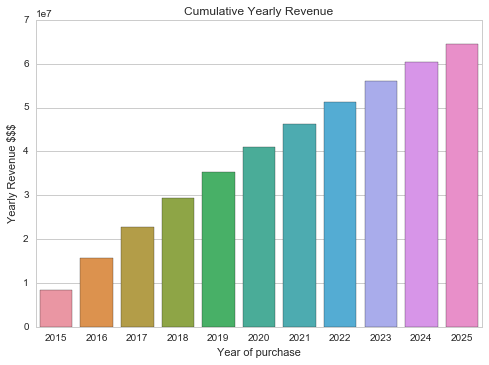

In [148]:
sns.set_style("whitegrid")
ax = sns.barplot(x=data.index, y=data.cumulative_revenue, data=data)
ax.set_xlabel("Year of purchase")
ax.set_ylabel("Yearly Revenue $$$")
ax.set_title("Cumulative Yearly Revenue");

In [149]:
discount_rate = 0.1

In [150]:
discount = [1/(1+discount_rate)**i for i in range(0,11)]

## Computing the discounted yearly revenue

In [151]:
disc_total_yearly_rev = prd(discount,total_yearly_rev)

In [152]:
disc_rev_df = pd.DataFrame({'discounted_yearly_revenue':disc_total_yearly_rev},index=[y for y in range(2015,2026)])
disc_rev_df

,discounted_yearly_revenue
2015,8.440171e+06
2016,6.682010e+06
2017,5.789319e+06
2018,4.891472e+06
2019,4.142058e+06
2020,3.514559e+06
2021,2.988687e+06
2022,2.547767e+06
2023,2.177587e+06
2024,1.866232e+06


** We can now find out how much the yealy revenue will decrease compared to the year 2015 taking into account the discount percentage: **

In [169]:
print('percentage of discouned yearly revenue decrease in 2025 relative to 2015:')
(disc_rev_df.loc[2025][0] - disc_rev_df.loc[2015][0])/disc_rev_df.loc[2015][0]

percentage of discouned yearly revenue decrease in 2025 relative to 2015:


-0.809982224246796

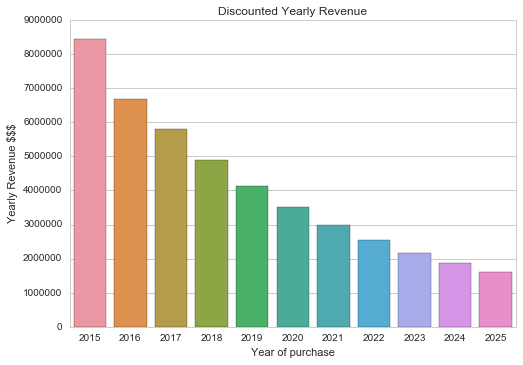

In [158]:
sns.set_style("whitegrid")
ax = sns.barplot(x=disc_rev_df.index, y="discounted_yearly_revenue", data=disc_rev_df)
ax.set_xlabel("Year of purchase")
ax.set_ylabel("Yearly Revenue $$$")
ax.set_title("Discounted Yearly Revenue");

In [159]:
yr_cumsum_disc = prd(total_yr_cusum,discount)

In [160]:
disc_cum_rev_df = pd.DataFrame({'discounted_cum_yearly_revenue':yr_cumsum_disc},index=[y for y in range(2015,2026)])
disc_cum_rev_df

,discounted_cum_yearly_revenue
2015,8.440171e+06
2016,1.435489e+07
2017,1.883922e+07
2018,2.201804e+07
2019,2.415846e+07
2020,2.547679e+07
2021,2.614941e+07
2022,2.631995e+07
2023,2.610482e+07
2024,2.559789e+07


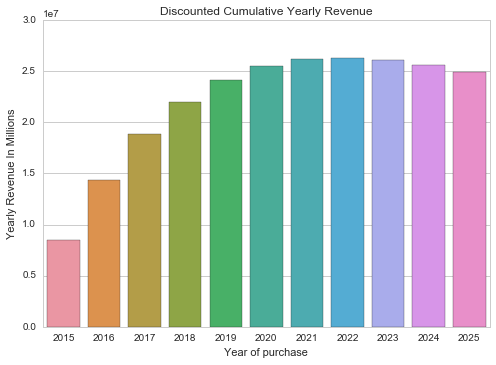

In [161]:
sns.set_style("whitegrid")
ax = sns.barplot(x=disc_cum_rev_df.index, y="discounted_cum_yearly_revenue", data=disc_cum_rev_df)
ax.set_xlabel("Year of purchase")
ax.set_ylabel("Yearly Revenue In Millions")
ax.set_title("Discounted Cumulative Yearly Revenue");

## How much is the customer database worth?


** We can now see that the net discounted cumulative total revenue in 2025 is projected to be little over 16 million and 434 thoudans USD: **

In [162]:
disc_cum_rev_df.iloc[10][0] - disc_rev_df.iloc[0][0]

16434416.430871712